In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


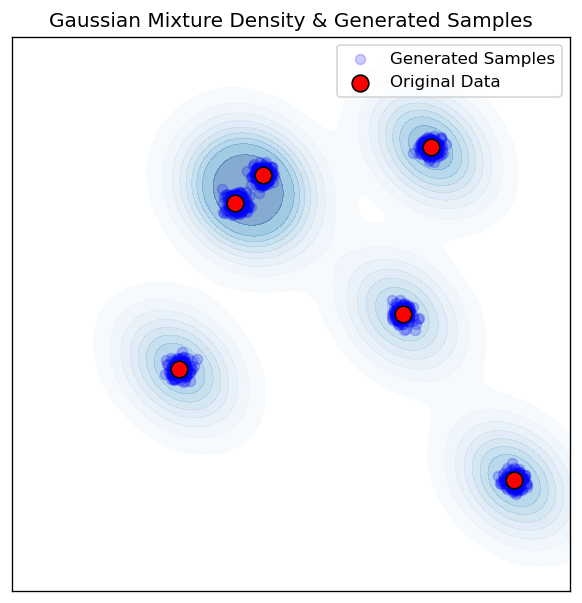

In [ ]:
d = 2
n = 6
y_data = torch.tensor([
    [0.9, 0.2],
    [0.75, 0.8],
    [0.3, 0.4],
    [0.4, 0.7],
    [0.45, 0.75],
    [0.7, 0.5]
], device=device)

def sample_from_gaussian_mixture(y_data, n_samples, std_dev=0.01, device='cpu'):
    n_centers, d = y_data.shape
    center_indices = torch.randint(0, n_centers, (n_samples,), device=device)
    chosen_centers = y_data[center_indices]
    noise = torch.randn(n_samples, d, device=device) * std_dev
    return chosen_centers + noise

samples = sample_from_gaussian_mixture(y_data, n_samples=1000, device=device)

def plot_density(y_data, samples, title="Density of Generated Samples"):
    plt.figure(figsize=(6, 6), dpi=120)
    
    # Density estimation
    samples_np = samples.cpu().numpy()
    sns.kdeplot(x=samples_np[:, 0], y=samples_np[:, 1], fill=True, cmap="Blues", alpha=0.5, levels=10)
    
    # Scatter plots
    plt.scatter(samples_np[:, 0], samples_np[:, 1], c='blue', alpha=0.2, label='Generated Samples')
    plt.scatter(y_data[:, 0].cpu(), y_data[:, 1].cpu(), c='red', edgecolors='black', s=100, label='Original Data')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(title)
    plt.legend()
    # remove all axis
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_density(y_data, samples, "Gaussian Mixture Density & Generated Samples")


In [3]:
class SWD_loss(nn.Module):
    """
    Computes the average 1D Wasserstein (Earth Mover) distance across
    multiple random projections of high-dimensional data.

    x, y are of shape (B, C, H, W). We'll flatten them to (B, D), then:
      - Sample random directions (n_projections, D)
      - Normalize each direction
      - Project x and y -> shape (B,) each, sort, take mean absolute diff
      - Average across all projections
    """
    def __init__(self, n_projections=5):
        super().__init__()
        self.n_projections = n_projections

    def forward(self, x, y):
        if len(x.shape) == 4:
            # x, y: (B, C, H, W). Flatten to (B, D)
            B, C, H, W = x.shape
            x_flat = x.view(B, -1)  # shape = (B, D)
            y_flat = y.view(B, -1)  # shape = (B, D)
        else : 
            x_flat = x
            y_flat = y
        device = x.device
        D = x_flat.shape[1]

        # Accumulate average Wasserstein distance across random projections
        wdist = 0.0
        for _ in range(self.n_projections):
            # Sample random direction vector
            direction = torch.randn(D, device=device)
            # Normalize to unit length
            direction = direction / (direction.norm(p=2) + 1e-8)

            # Project onto this direction => shape (B,)
            x_proj = x_flat @ direction
            y_proj = y_flat @ direction

            # Sort
            x_sorted, _ = torch.sort(x_proj)
            y_sorted, _ = torch.sort(y_proj)

            # 1D Wasserstein distance: mean of |sorted(x) - sorted(y)|
            wdist += torch.mean(torch.abs(x_sorted - y_sorted))

        return wdist / self.n_projections

In [4]:
class Generator(nn.Module):
    def __init__(self, n_in=10, n_out=2, n_hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hid),
            nn.ELU(),
            nn.Linear(n_hid, n_hid),
            nn.ELU(),
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        )
        self._init_weights()

    def forward(self, z):
        return self.net(z)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

class DGAN(nn.Module):
    def __init__(self, n_in=2, n_hid=64):
        super().__init__()
        
        # The first part (net1): up to the second LeakyReLU
        self.net1 = nn.Sequential(
            nn.Linear(n_in, n_hid),
            nn.LeakyReLU(0.2),
            nn.Linear(n_hid, n_hid)
        )
        
        # The second part (net2): last Linear + Sigmoid
        self.net2 = nn.Sequential(
            nn.Linear(n_hid, 1),
            nn.Sigmoid()
        )

    def forward(self, x, return_intermediate=False):
        x1 = self.net1(x)  # Intermediate features
        x2 = nn.LeakyReLU(0.2)(x1)  # Intermediate features
        x2 = self.net2(x2) # Final output
        if return_intermediate:
            return x1, x2
        else : 
            return x2


## GAN Normal

Epoch [10/200] - Dloss=1.1907, Gloss=0.7840
Epoch [20/200] - Dloss=1.1771, Gloss=0.8685
Epoch [30/200] - Dloss=1.0793, Gloss=0.8696
Epoch [40/200] - Dloss=1.1461, Gloss=1.0754
Epoch [50/200] - Dloss=1.2375, Gloss=0.9315
Epoch [60/200] - Dloss=1.1510, Gloss=0.9083
Epoch [70/200] - Dloss=1.1625, Gloss=0.8134
Epoch [80/200] - Dloss=1.1083, Gloss=0.9225
Epoch [90/200] - Dloss=1.1668, Gloss=0.9178
Epoch [100/200] - Dloss=1.0956, Gloss=1.1915
Epoch [110/200] - Dloss=1.1783, Gloss=0.8011
Epoch [120/200] - Dloss=1.1958, Gloss=0.9740
Epoch [130/200] - Dloss=1.0974, Gloss=1.0985
Epoch [140/200] - Dloss=1.0907, Gloss=1.1333
Epoch [150/200] - Dloss=1.1061, Gloss=0.8157
Epoch [160/200] - Dloss=1.0519, Gloss=1.1908
Epoch [170/200] - Dloss=1.0832, Gloss=0.9387
Epoch [180/200] - Dloss=1.2566, Gloss=0.7927
Epoch [190/200] - Dloss=1.2103, Gloss=0.8583
Epoch [200/200] - Dloss=1.0564, Gloss=1.0788


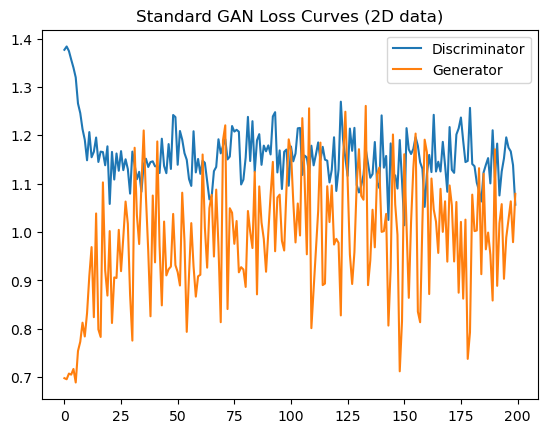

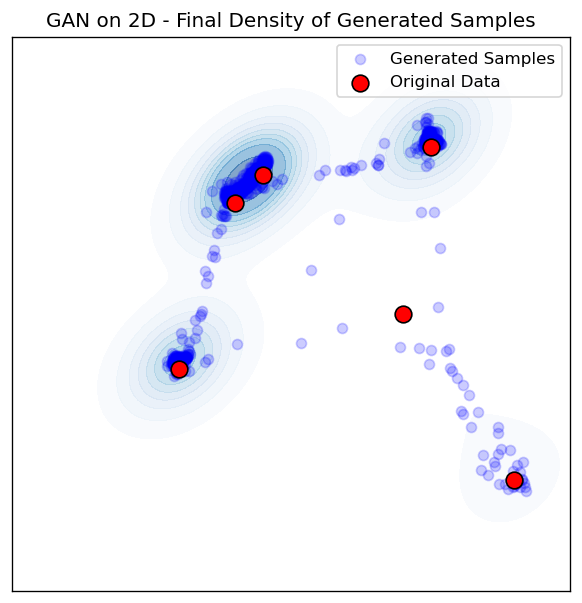

In [5]:
torch.manual_seed(1)
n_in = 10
G_gan = Generator(n_in=n_in, n_out=d, n_hid=64).to(device)
D_gan = DGAN(n_in=d, n_hid=64).to(device)

lr_gan = 5e-2
betas = (0.5, 0.999)
optimG_gan = optim.Adam(G_gan.parameters(), lr=lr_gan/100, betas=betas)
optimD_gan = optim.Adam(D_gan.parameters(), lr=lr_gan/100, betas=betas)
# optimG_gan = optim.SGD(G_gan.parameters(), lr=lr_gan)
# optimD_gan = optim.SGD(D_gan.parameters(), lr=lr_gan)

n_epochs = 200
batch_size = 128

Dlosses, Glosses = [], []

for epoch in range(n_epochs):
    for _ in range(200):
        optimD_gan.zero_grad()
        x_real = sample_from_gaussian_mixture(y_data, batch_size, device=device)
        Dy = D_gan(x_real)
        z = torch.randn(batch_size, n_in, device=device)
        x_fake = G_gan(z).detach()
        Dx_fake = D_gan(x_fake)
        lossD = -torch.mean(torch.log(Dy + 1e-9)) - torch.mean(torch.log(1. - Dx_fake + 1e-9))
        lossD.backward()
        optimD_gan.step()

        optimG_gan.zero_grad()
        z = torch.randn(batch_size, n_in, device=device)
        x_fake = G_gan(z)
        Dx = D_gan(x_fake)
        lossG = -torch.mean(torch.log(Dx + 1e-9))
        lossG.backward()
        optimG_gan.step()

    Dlosses.append(lossD.item())
    Glosses.append(lossG.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] - Dloss={lossD.item():.4f}, Gloss={lossG.item():.4f}")

plt.figure(dpi=100)
plt.plot(Dlosses, label='Discriminator')
plt.plot(Glosses, label='Generator')
plt.title("Standard GAN Loss Curves (2D data)")
plt.legend()
plt.show()

z_plot = torch.randn(1000, n_in, device=device)
x_plot = G_gan(z_plot).detach()
plot_density(y_data, x_plot, "GAN on 2D - Final Density of Generated Samples")

Epoch [10/200] - Dloss=1.3371, Gloss=0.0313
Epoch [20/200] - Dloss=1.2954, Gloss=0.0827
Epoch [30/200] - Dloss=1.2117, Gloss=0.1074
Epoch [40/200] - Dloss=1.1523, Gloss=0.0976
Epoch [50/200] - Dloss=0.9150, Gloss=0.1150
Epoch [60/200] - Dloss=0.7758, Gloss=0.1531
Epoch [70/200] - Dloss=0.9689, Gloss=0.2048
Epoch [80/200] - Dloss=0.8943, Gloss=0.2167
Epoch [90/200] - Dloss=0.8356, Gloss=0.2906
Epoch [100/200] - Dloss=1.3117, Gloss=0.1852
Epoch [110/200] - Dloss=1.1376, Gloss=0.1903
Epoch [120/200] - Dloss=0.9086, Gloss=0.2313
Epoch [130/200] - Dloss=0.8513, Gloss=0.3255
Epoch [140/200] - Dloss=0.9246, Gloss=0.3111
Epoch [150/200] - Dloss=0.9423, Gloss=0.2112
Epoch [160/200] - Dloss=0.8629, Gloss=0.2844
Epoch [170/200] - Dloss=1.1834, Gloss=0.2958
Epoch [180/200] - Dloss=0.9780, Gloss=0.2385
Epoch [190/200] - Dloss=0.9959, Gloss=0.2171
Epoch [200/200] - Dloss=1.0635, Gloss=0.2471


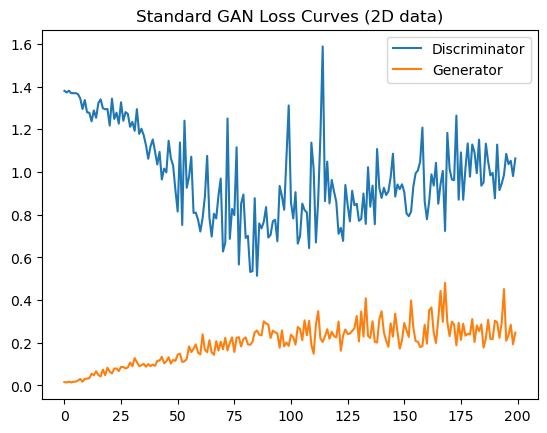

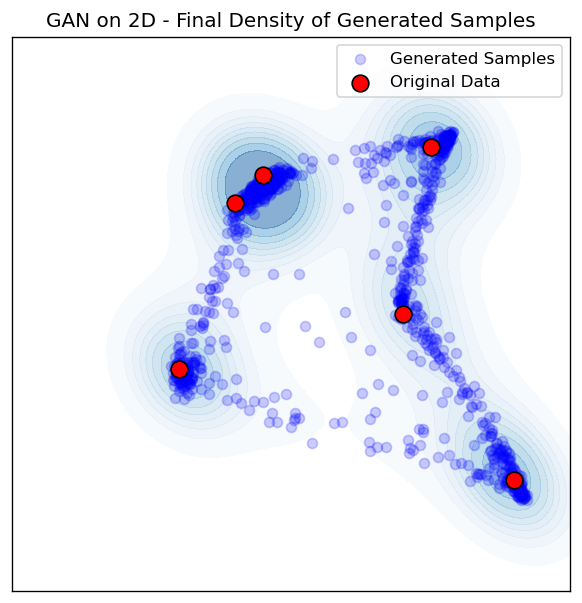

In [6]:
torch.manual_seed(1)
n_in = 10
G_gan_sw = Generator(n_in=n_in, n_out=d, n_hid=64).to(device)
D_gan_sw = DGAN(n_in=d, n_hid=64).to(device)

lr_gan = 5e-2
betas = (0.5, 0.999)
# optimG_gan = optim.Adam(G_gan_sw.parameters(), lr=lr_gan/100, betas=betas)
# optimD_gan = optim.Adam(D_gan_sw.parameters(), lr=lr_gan/100, betas=betas)
optimG_gan = optim.SGD(G_gan_sw.parameters(), lr=lr_gan)
optimD_gan = optim.SGD(D_gan_sw.parameters(), lr=lr_gan)

n_epochs = 200
batch_size = 128

swd_loss = SWD_loss(n_projections=30)

Dlosses, Glosses = [], []

for epoch in range(n_epochs):
    for _ in range(200):
        
        optimD_gan.zero_grad()
        x_real = sample_from_gaussian_mixture(y_data, batch_size, device=device)
        Dyint, Dy = D_gan_sw(x_real, return_intermediate=True)
        z = torch.randn(batch_size, n_in, device=device)
        x_fake = G_gan_sw(z).detach()
        Dx_fake = D_gan_sw(x_fake)
        lossD = -torch.mean(torch.log(Dy + 1e-9)) - torch.mean(torch.log(1. - Dx_fake + 1e-9))
        lossD.backward()
        optimD_gan.step()

        with torch.no_grad():
            x_real = sample_from_gaussian_mixture(y_data, batch_size, device=device)
            Dyint, _ = D_gan_sw(x_real, return_intermediate=True)

        optimG_gan.zero_grad()
        z = torch.randn(batch_size, n_in, device=device)
        x_fake = G_gan_sw(z)
        Dxint, Dx = D_gan_sw(x_fake, return_intermediate=True)
        lossG = swd_loss(Dyint, Dxint)
        lossG.backward()
        optimG_gan.step()

    Dlosses.append(lossD.item())
    Glosses.append(lossG.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] - Dloss={lossD.item():.4f}, Gloss={lossG.item():.4f}")

plt.figure(dpi=100)
plt.plot(Dlosses, label='Discriminator')
plt.plot(Glosses, label='Generator')
plt.title("Standard GAN Loss Curves (2D data)")
plt.legend()
plt.show()

z_plot = torch.randn(1000, n_in, device=device)
x_plot = G_gan_sw(z_plot).detach()
plot_density(y_data, x_plot, "GAN on 2D - Final Density of Generated Samples")